In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

Demonstration of Knowledge Distillation in Neural Networks on Simple MNIST Dataset

Knowledge distillation is a technique where a large, well-trained teacher model transfers its knowledge to a smaller student model by providing soft labels (probabilistic outputs) instead of just hard class labels. This helps the student model learn more efficiently, often achieving comparable accuracy to the teacher despite having fewer parameters. By mimicking the teacher's outputs, the student can generalize better and learn deeper patterns that would be harder to capture through direct training.

Best Scenarios Where Knowledge Distillation Works Well :

✅ When the student model is much smaller than the teacher – Helps retain key knowledge while reducing computational costs.

✅ Limited training data – Soft targets from the teacher encode richer class relationships, improving generalization.

✅ Deployment on edge devices – Enables efficient AI models for mobile and IoT applications.

✅ When different architectures are used – Works even if the teacher and student have different structures (e.g., CNN to MLP).

✅ To improve generalization – Helps the student avoid overfitting by leveraging structured knowledge from the teacher.

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
        
    def compile(
        self,
        optimizer,  # Optimizer for training the student model
        metrics,  # Metrics to evaluate performance
        student_loss_fn,  # Loss function for the student model
        distillation_loss_fn,  # Loss function for distillation
        alpha=0.5,  # Weight for the student loss
        temperature=2,  # Temperature for distillation
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
        
    def compute_loss(
        self,
        x=None,
        y=None,
        y_pred=None,
        sample_weight=None,
        allow_empty=False
    ):
        # Get the teacher's predictions
        teacher_predictions = self.teacher(x, training=False)
        
        # Compute the softmax of the teacher's predictions and student's predictions with temperature scaling
        temp_softmax_teacher = tf.nn.softmax(teacher_predictions / self.temperature)
        temp_softmax_stu_with_temp = tf.nn.softmax(y_pred / self.temperature)
        
        # Compute the student loss using the student loss function
        student_loss = self.student_loss_fn(y, y_pred)  # y_pred is softmaxed as from_logits=True is set 
        
        # Compute the distillation loss using the distillation loss function
        distillation_loss = self.distillation_loss_fn(temp_softmax_teacher, temp_softmax_stu_with_temp)
        
        # Return the weighted sum of the student loss and distillation loss
        return self.alpha * student_loss + (1 - self.alpha) * distillation_loss * (self.temperature ** 2)
        
    def call(self,inputs):
         return self.student(inputs)
        

In [67]:
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28,1)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(32,  activation='relu'),
        keras.layers.Dense(10),
    ],
    name="teacher",
)

student = keras.Sequential(
    [
        keras.Input(shape=(28, 28,1)),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(10),
    ],
    name="student",
)

student_scratch = keras.models.clone_model(student)

In [86]:
(X_train,y_train),(X_test,y_test) = keras.datasets.mnist.load_data()

In [87]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [56]:
teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

his = teacher.fit(X_train, y_train, epochs=12,validation_split=0.2)

Epoch 1/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9922 - val_loss: 0.0358 - val_sparse_categorical_accuracy: 0.9885
Epoch 2/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9948 - val_loss: 0.0651 - val_sparse_categorical_accuracy: 0.9832
Epoch 3/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0120 - sparse_categorical_accuracy: 0.9965 - val_loss: 0.0524 - val_sparse_categorical_accuracy: 0.9866
Epoch 4/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9970 - val_loss: 0.0651 - val_sparse_categorical_accuracy: 0.9835
Epoch 5/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.0612 - val_sparse_categorical_accuracy: 0.9855
Epoch 6/12
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.0751 - val_sparse_categorical_accur

In [88]:
distiller = Distiller(student=student, teacher=teacher)

distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=8,
)


In [89]:
his_dis = distiller.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9954
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9972
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0170 - sparse_categorical_accuracy: 0.9979
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0168 - sparse_categorical_accuracy: 0.9982
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0163 - sparse_categorical_accuracy: 0.9984


In [90]:
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

his_scratch = student_scratch.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0115 - sparse_categorical_accuracy: 0.9959
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.0088 - sparse_categorical_accuracy: 0.9970
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9971
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0061 - sparse_categorical_accuracy: 0.9982
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0068 - sparse_categorical_accuracy: 0.9978


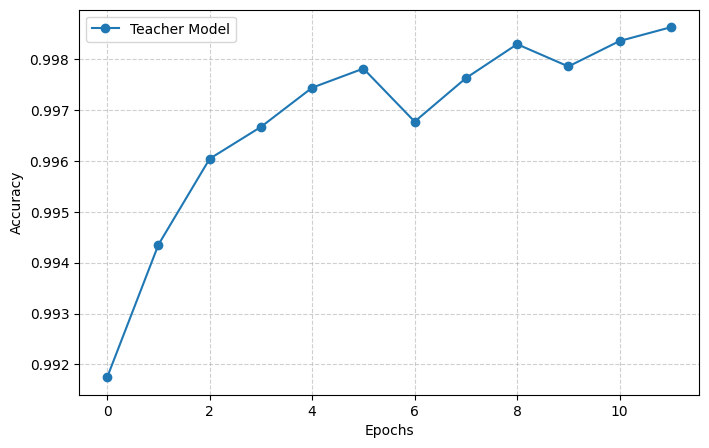

In [98]:
plt.figure(figsize=(8, 5))
plt.plot(his.history['sparse_categorical_accuracy'], label="Teacher Model", marker='o')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")


plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()


plt.show()

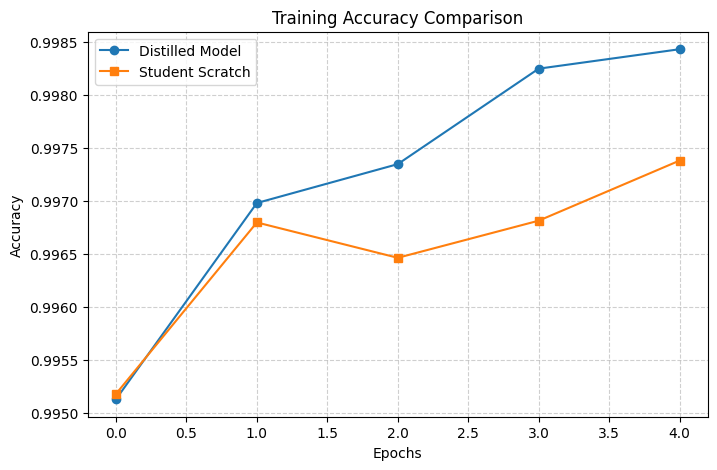

In [97]:
plt.figure(figsize=(8, 5))
plt.plot(his_dis.history['sparse_categorical_accuracy'], label="Distilled Model", marker='o')
plt.plot(his_scratch.history['sparse_categorical_accuracy'], label="Student Scratch", marker='s')


plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Comparison")


plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()


plt.show()

From the plot, we observe that the distilled model consistently outperforms the student trained from scratch across all epochs. The key takeaway is that the distilled student model is able to mimic the teacher’s knowledge more effectively, leading to a smoother and more stable learning curve. The gap between the distilled model and the scratch model suggests that knowledge distillation helps in transferring structured knowledge, making training more efficient.

Although both models start at nearly the same accuracy in the first epoch, the distilled model quickly surpasses the scratch model in later epochs. This shows that distillation enables faster convergence and better generalization, particularly when the student model is smaller than the teacher. The scratch model exhibits slight fluctuations in accuracy, which may indicate less stable learning compared to the distilled version.

MoreOver , Experiments can be made by changing alpha and temperate parameter

In [95]:
#Written by Haseeb Asif